In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd

import urllib.request
from bs4 import BeautifulSoup

import matplotlib
from matplotlib import pyplot as plt
plt.style.use('ggplot')

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [287]:
class PicNicPlanner(object):
    
    RAIN_URL = 'http://ggweather.com/sf/daily.html'
    TEMP_URL = 'http://ggweather.com/sf/monthly%20mean%20temps.html'
    
    def __init__(self):
        self.rain_table = None
        self.temperature_table = None
    
    def _read_soup(self, url, split='\t'):
        flob = urllib.request.urlopen(url)
        s = flob.read()
        flob.close()
        soup = BeautifulSoup(s, "lxml")
        return [s for s in soup.findAll('table')[1].get_text().split(split) if len(s)>0]
    
    def _clean_rain(self, row):
        return pd.Series(row.strip().split('\n')[1:]).astype(float) 
    
    def get_rains(self):
        if self.rain_table is None:
            raw_rows = self._read_soup(self.RAIN_URL, '\xa0')
            cleaned_rows = pd.concat(
                [self._clean_rain(row) for row in raw_rows if 'Days' in row and 'Rain' not in row], 
                axis=1)
            cleaned_rows.index = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
                                  'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
            self.rain_table = cleaned_rows.transpose()
            self.rain_table.index = list(range(2008,2018))
        return self.rain_table
        
    def _clean_temperatures(self, row):
        if len(row) > 1 and not (
            'Copyright' in row or 
            'Reproduction' in row or 
            'San Francisco' in row):
            return pd.Series(row.strip().split('\n'))
    
    def get_temperatures(self):
        if self.temperature_table is None:
            raw_rows = self._read_soup(self.TEMP_URL)
            cleaned_rows = pd.concat([self._clean_temperatures(row) 
                                      for row in raw_rows[2:]],axis=1)
            cleaned_rows.columns = cleaned_rows.iloc[0]
            cleaned_rows = cleaned_rows.drop(0).dropna(axis=0)
            cleaned_rows.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Annual']
            self.temperature_table = cleaned_rows.transpose()
            self.temperature_table = self.temperature_table.astype(float)
        return self.temperature_table
        
        
def num_days(month):
    if month in ['Nov', 'Apr', 'Jun', 'Sep']:
        return 30
    if month == 'Feb':
        return 28
    return 31
    

In [288]:
planner = PicNicPlanner()
temp = planner.get_temperatures()
rains = planner.get_rains()

Text(0.5,0,'Month')

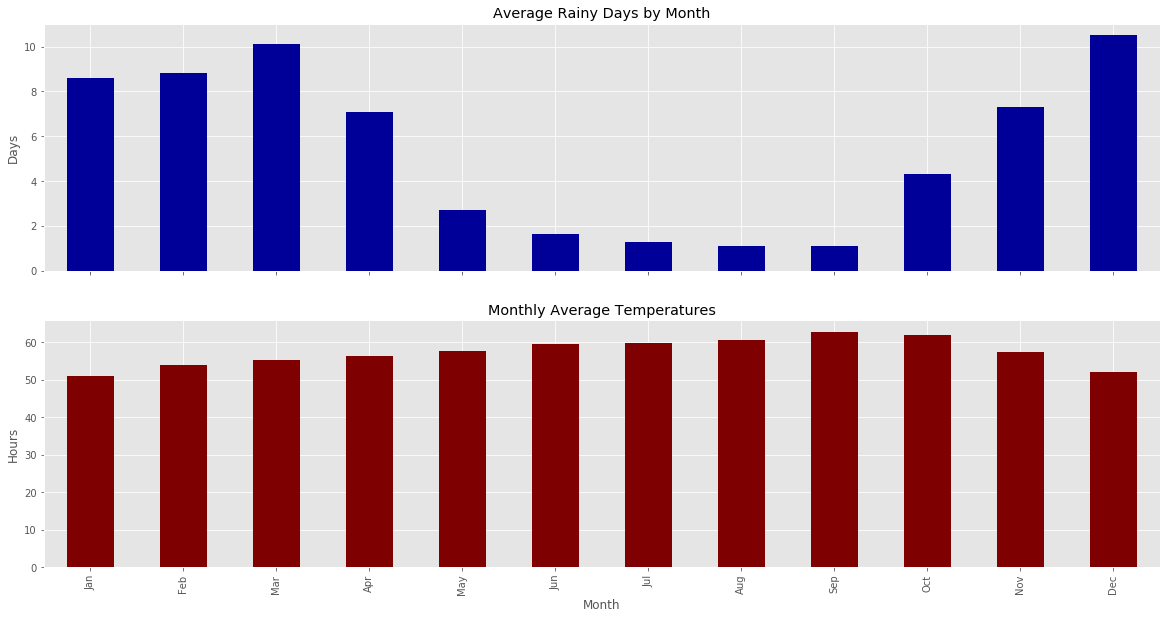

In [289]:
fig, axes = plt.subplots(nrows=2, ncols=1)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0].set_title('Average Rainy Days by Month')
axes[1].set_title('Monthly Average Temperatures')

rains.mean()[months].plot(kind='bar', ax=axes[0], sharex=True, color='#000099')
axes[0].set_ylabel('Days')
temp.mean()[months].plot(kind='bar', ax=axes[1], color='#7f0000')
axes[1].set_ylabel('Hours')
axes[1].set_xlabel('Month')

In [290]:
pd.DataFrame({'Daily Chances of Rain': 100*rains.mean() / rains.columns.map(num_days)}).loc[months]

,Daily Chances of Rain
Jan,27.741935
Feb,31.428571
Mar,32.580645
Apr,23.666667
May,8.709677
Jun,5.416667
Jul,4.193548
Aug,3.548387
Sep,3.666667
Oct,13.870968


So, having a picnic in SF in April is not the best idea... May on the other hand...